<a href="https://colab.research.google.com/github/josegoisgit/dadosgov/blob/main/dados_de_governos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bandeiras

1.   Transparência digital
2.   Dados abertos



Informações

https://dados.gov.br/pagina/sobre

https://www.oecd.org/gov/open-government-data-report-9789264305847-en.htm

http://www.oecd.org/gov/digital-government/open-government-data.htm

https://en.wikipedia.org/wiki/Open_by_default

https://theunitedstates.io/licensing

https://www.w3.org/2017/12/odi-study/

https://www.w3.org/TR/vocab-dcat/

In [1]:
alias_url = {
    'Australia' : 'data.gov.au',
    'Austria' : 'data.gv.at',
    'Belgium' : 'data.gov.be',
    'Brazil'  : 'dados.gov.br',
    'Canada' : 'open.canada.ca',
    'Chile' : 'datos.gob.cl',
    'Colombia' :'datos.gob.co',
    'Denmark' : 'www.digitaliser.dk/cataloues',
    'Dominican Republic' : 'www.datos.gob.do',
    'Estonia' : 'opendata.riik.ee',
    'Finland' : 'avoindata.fi/fi',
    'France' : 'data.gouv.fr',
    'Germany' : 'govdata.de',
    'Greece' : 'data.gov.gr',
    'Ireland' : 'data.gov.ie',
    'Israel' : 'data.gov.il',
    'Italy' : 'dati.gov.it',
    'Japan' : 'data.go.jp',
    'Korea' : 'data.go.kr',
    'Latvia' : 'data.gov.lv',
    'Lithuania' : 'data.gov.lt',
    'Mexico' : 'datos.gob.mx',
    'Netherlands' : 'data.overheid.nl',
    'Norway' : 'data.norge.no',
    'Peru' : 'datosabiertos.gob.pe',
    'Poland' : 'danepubliczene.gov.pl',
    'Portugal' : 'dados.gov.pt',
    'Slovenia' : 'data.gov.si',
    'Spain' : 'datos.gob.es',
    'Sweden' : 'oppnadata.se',
    'Switzeland' : 'opendata.swiss',
    'Czech Republic' : 'data.gov.cz',
    'New Zealand' : 'data.govt.nz',
    'Slovak Republic' : 'data.gov.sk',
    'United Kingdom' : 'data.gov.uk',
    'Uniteds States' : 'data.gov'
}

In [2]:
alias = 'Brazil'
hyperlink = 'https://'+alias_url[alias]

In [3]:
query     = 'UFRN discentes'

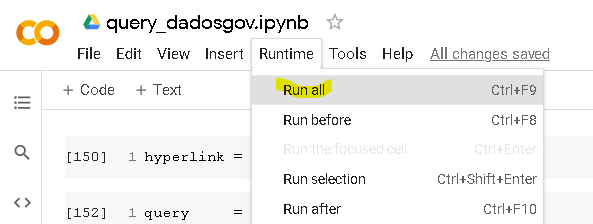

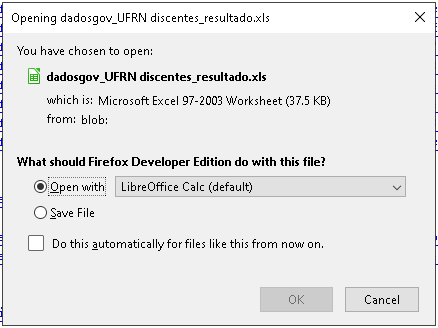

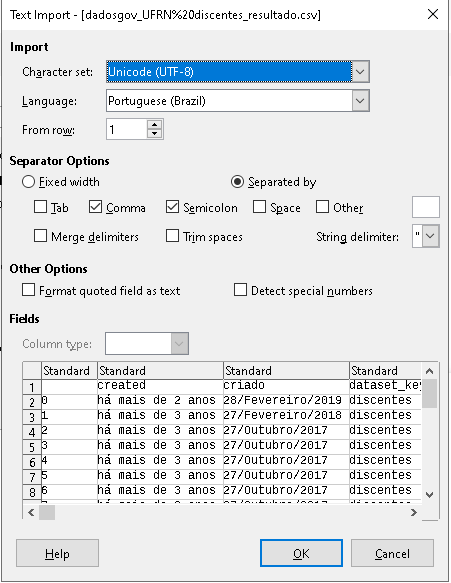

# Módulos e pacotes

## Instalação

In [4]:
!pip install unidecode

## Importação

In [5]:
import re
import requests
import pandas

from unidecode import unidecode

from itertools import chain
from lxml.etree import HTML

import IPython
import ipywidgets
import google.colab

# Funções

## auxiliares

#### lambdas

##### strip

In [6]:
strip_ = lambda T: set( t.strip() for t in T if t.strip() )
strip  = lambda T: '\n'.join( strip_( T ) ).strip()

##### plain

In [7]:


plain  = lambda I: list( chain.from_iterable( I ) )


## get_url_html

In [8]:
def get_url_html(url):
    requested         = requests.request('GET', url)
    html              = HTML(requested.text)    
    html.nsmap['url'] = url

    return html


In [9]:
#Exemplo:
html = get_url_html('https://docs.python.org')
html.xpath('.//a/@href')

['genindex.html',
 'py-modindex.html',
 'https://www.python.org/',
 '#',
 'whatsnew/3.9.html',
 'whatsnew/index.html',
 'tutorial/index.html',
 'library/index.html',
 'reference/index.html',
 'using/index.html',
 'howto/index.html',
 'installing/index.html',
 'distributing/index.html',
 'extending/index.html',
 'c-api/index.html',
 'faq/index.html',
 'py-modindex.html',
 'genindex.html',
 'glossary.html',
 'search.html',
 'contents.html',
 'bugs.html',
 'https://devguide.python.org/docquality/#helping-with-documentation',
 'about.html',
 'license.html',
 'copyright.html',
 'download.html',
 'https://docs.python.org/3.10/',
 'https://docs.python.org/3.9/',
 'https://docs.python.org/3.8/',
 'https://docs.python.org/3.7/',
 'https://docs.python.org/3.6/',
 'https://docs.python.org/3.5/',
 'https://docs.python.org/2.7/',
 'https://www.python.org/doc/versions/',
 'https://www.python.org/dev/peps/',
 'https://wiki.python.org/moin/BeginnersGuide',
 'https://wiki.python.org/moin/PythonBooks',


## xpath

### contains_clause

In [10]:
def contains_clause(dic, operator='OR'):
    predicados = ["contains(@{k},'{v}')".format(k=k,v=v) for k,v in dic.items()]

    return operator.join(predicados)


### compose_xpath

In [11]:

def compose_xpath(element,attribute,content):
    dictionary = contains_clause({attribute:content})

    str_dict = {
        'element' : element,
        'dictionary' : dictionary 
    }

    return "{element}[{dictionary}]".format(**str_dict)


### get_xnodes

In [12]:

def get_xnodes(html, element, attribute='class', content='', complement=''):
    if complement:
        xnode = html.xpath(compose_xpath(element,attribute,content) + complement)
    else:
        xnode = html.xpath(compose_xpath(element,attribute,content) )
    return xnode if xnode else None


### get_xnode

In [13]:

def get_xnode(html, element, attribute='class', content='', complement=''):
    xnodes = get_xnodes(html, element, attribute, content, complement)
    return xnodes[0] if xnodes else None


## datasets

### get_html_page_count

In [14]:
 
def get_html_page_count(html):
    xnode = get_xnode( html, '//div', 'class', 'pagination' ) 
    
    if xnode is None:
        return 1
    
    pdiv = xnode.xpath( '//li/a/text()' )
    
    def pmax(pdiv):
        V = [1]
        for p in pdiv:
            try:
                v = int(p)
                V.append(v)       
            except:
                continue
        return max(V)    
    return pmax(pdiv)

### get_query_page_count

In [15]:

def get_query_page_count(hyperlink,query):
    html = get_url_html( hyperlink + '/dataset?q=%s' % query)
    return get_html_page_count( html )


### get_html_items_href






In [16]:

def get_html_items_href(html):
    xnodes = get_xnodes( html, './/h3', 'class', 'dataset-heading' , '//a/@href' ) 
    return xnodes


### get_html_dataset

In [35]:

def get_html_dataset(html):    
    article_html = get_xnode(html , '//article')
    
    dataset = dict()
    
    dataset['organization'] = ' '.join([x.strip() for x in get_xnodes(html, './/section','class','module-content','//h1//text()')])
    dataset['title']        = strip( get_xnodes( article_html , 'div/h1/text()') ) 
    dataset['key']          = re.sub('[^\w]','_',unidecode(dataset['title']).lower())
    z = get_xnodes(article_html,'//div','class','notes','//p/text()')
    dataset['text'] = strip(z) if z else ''
    dataset['url']          = get_xnodes( article_html, '//ol', 'class', 'breadcrumb', '//li/a/@href')

    return dataset


### get_html_dataset_license

In [18]:

def get_html_dataset_license(html,hyperlink='https://dados.gov.br'):
    xnode = get_xnode( html, '//section','class','license') 

    if not xnode: return dict(title='NA',href='',text='',logo='')

    license_title = xnode.xpath( './/@title' )
    license_href  = xnode.xpath( './/@href')
    license_text  = [ text.strip() for text in xnode.xpath( './/text()' ) if text.strip() ]
    license_logo  = [ hyperlink + p for p in xnode.xpath( './/img//@src' ) ]
    
    license_dict          = dict()
    license_dict['title'] = license_title
    license_dict['href']  = license_href
    license_dict['text']  = license_text
    license_dict['logo']  = license_logo

    return license_dict


### get_html_dataset_resources_href

In [19]:

def get_html_dataset_resources_href(html):
    return get_xnodes(html,'//a','class','heading','/@href')


### get_html_resource_info





In [38]:

def get_html_resource_info(html):
    
    ths     = get_xnodes( html, '//table', 'class', 'table-condensed','/tbody//th/text()')
    headers = [re.sub('[^\w]','_',unidecode(th.lower())) for th in ths]
    tds     = get_xnodes( html, '//table', 'class', 'table-condensed','/tbody//td')
    data    = [strip(get_xnodes(td, './/text()')).strip() for td in tds]

    info_dict        = {h:d for h,d in zip(headers,data)}
    info_dict['url'] = str(get_xnode( html, '//a','class','resource-url-analytic','/@href'))

    return info_dict

### auxiliares

#### \_\_dir_repr\_\_

In [21]:

def __dir_repr__(variable=dict,pattern=''):
    dir_type_dict = dict()
    
    for attribute in dir(variable):
        if not re.findall(pattern, attribute): continue
        value = getattr(variable,attribute)
        typename = type(value).__name__
        
        if typename not in dir_type_dict:
            dir_type_dict[typename] = [(attribute,value)]
        else:
            dir_type_dict[typename].append((attribute,value))
        
    for key, items in dir_type_dict.items():
        print(key)
        print()
        for attribute,value in items:
            print('\t',attribute)
        print()
        #print('{: <30s}{:<20s}'.format(typename, attribute))


#### show_url

In [22]:

def show_url( url='https://dados.gov.br'):
    dadosgov_frame = IPython.display.IFrame(src=url,width='100%',height='500px')
    display(dadosgov_frame)
    return


#### query_site

In [23]:

def query_site( query=''):
    query = query.lower()
    query = unidecode.unidecode(query)
    query = re.sub('[^a-z\s\'\"]','',query)
    query = re.sub('\s+','+',query)
    
    url = 'https://dados.gov.br/dataset?q=%s' % query
    dadosgov_frame = IPython.display.IFrame(src=url,width='100%',height='500px')
    display(dadosgov_frame)
    return dadosgov_frame



#### lambdas

##### get_query_page_url

In [24]:
get_query_page_url   = lambda h, q, p : h + '/dataset' + '?q=' + q + '&page=' + str(p)

##### get_query_page_html

In [25]:
get_query_page_html  = lambda h, q, p : get_url_html( get_query_page_url( h, q, p ) )


##### get_query_page_items

In [26]:
get_query_page_items = lambda h, q, p : get_html_items_href( get_query_page_html( h, q, p ) )


##### get_query_items_href

In [27]:
get_query_items_href = lambda h, q    : plain([ get_query_page_items( h, q, p+1 ) for p in range( get_query_page_count( h, q ) ) ])


# Leitura

## argumentos

In [28]:
query   = re.sub('[^\w]',' ',unidecode(query))
query   = re.sub('\s+'  ,' ',query)
query   = re.sub('\s'   ,'+',query)

query

'UFRN+discentes'

In [29]:
query_url = get_query_page_url(hyperlink,query,1)

In [30]:
show_url(query_url)

## visualização

In [31]:
resources = []
items_href = get_query_items_href(hyperlink,query)

In [32]:
ih = 0
 
print(hyperlink + items_href[ih])
show_url(hyperlink + items_href[ih])

https://dados.gov.br/dataset/discentes


## arquivos

In [33]:
import time

In [39]:
import pandas
resources = []
for item_href in items_href:
    item_url = hyperlink + item_href
 
    print('\n\n\t', item_url, end='\n\n')
    dataset_html   = get_url_html( item_url )
 
    dataset        = get_html_dataset( dataset_html )
    license        = get_html_dataset_license ( dataset_html )
    resources_href = get_html_dataset_resources_href( dataset_html )
 
    for resource_href in resources_href:
        resource_url  = hyperlink + resource_href 
 
        resource_html = get_url_html( resource_url )  
        resource_dict = get_html_resource_info(resource_html)
 
        a = 'http://landpage-h.cgu.gov.br/dadosabertos/index.php?url='
        resource_dict['url_out'] = resource_dict['url'].replace(a,'') if resource_dict['url'] else None        

        resource_dict.update({('dataset_'+k):v for k,v in dataset.items()})
        resource_dict.update({('license_'+k):v for k,v in license.items()})
 
        resource_dict['havested'] = time.ctime()
        
        print('\t\t',resource_dict['url_out'], end='\n')
 
        resources.append( resource_dict )



	 https://dados.gov.br/dataset/discentes



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  """


		 http://dados.ufrn.br/dataset/554c2d41-cfce-4278-93c6-eb9aa49c5d16/resource/a55aef81-e094-4267-8643-f283524e3dd7/download/discentes-2019.csv
		 http://dados.ufrn.br/dataset/554c2d41-cfce-4278-93c6-eb9aa49c5d16/resource/146b749b-b9d0-49b2-b114-ac6cc82a4051/download/discentes-2018.csv
		 http://dados.ufrn.br/dataset/554c2d41-cfce-4278-93c6-eb9aa49c5d16/resource/dc732572-a51a-4d4a-a39d-2db37cbe5382/download/discentes-2017.csv
		 http://dados.ufrn.br/dataset/554c2d41-cfce-4278-93c6-eb9aa49c5d16/resource/7d2fa5b3-743f-465f-8450-91719b34a002/download/discentes-2016.csv
		 http://dados.ufrn.br/dataset/554c2d41-cfce-4278-93c6-eb9aa49c5d16/resource/e2b5b843-4f58-497e-8979-44daf8df8f94/download/discentes-2015.csv
		 http://dados.ufrn.br/dataset/554c2d41-cfce-4278-93c6-eb9aa49c5d16/resource/6c23a430-9a7c-4d0f-9602-1d5d97d40e6a/download/discentes-2014.csv
		 http://dados.ufrn.br/dataset/554c2d41-cfce-4278-93c6-eb9aa49c5d16/resource/dba208c2-822f-4e26-adc3-b61d4cb110b6/download/discentes-2013.csv

# Dados

In [40]:
df_datagov = pandas.DataFrame(resources)

In [41]:
df_datagov = df_datagov[sorted(df_datagov.keys())]

In [42]:
df_datagov.sample(3).T

,27,36,3
created,há mais de 3 anos,há 5 meses,há mais de 3 anos
criado,23/Novembro/2017,9/Novembro/2020,27/Outubro/2017
dataset_key,dados_socio_economicos_de_discentes,dados_socio_economicos_de_discentes,discentes
dataset_organization,Universidade Federal do Rio Grande do Norte - ...,Universidade Federal do Rio Grande do Norte - ...,Universidade Federal do Rio Grande do Norte - ...
dataset_text,Obs.: os identificadores dos discentes encontr...,Obs.: os identificadores dos discentes encontr...,Relação dos discentes da UFRN.
dataset_title,Dados Sócio-Econômicos de Discentes,Dados Sócio-Econômicos de Discentes,Discentes
dataset_url,"[/, /organization, /organization/universidade-...","[/, /organization, /organization/universidade-...","[/, /organization, /organization/universidade-..."
datastore_active,True,True,NaN
format,CSV,CSV,CSV
formato,CSV,CSV,CSV


In [45]:
FN = lambda ext='json' : './dadosgov_{}_{}_query.{}'.format(alias,query.replace('+','_'), ext)
 
 
df_datagov.to_json(FN('json'))
df_datagov.to_csv(FN('csv'))
df_datagov.to_excel(FN('xls'))
for fn in ['json', 'csv', 'xls']:
    google.colab.files.download(FN(fn))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>